In [21]:
import matplotlib
#matplotlib.use('Agg')
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter

# Para manejar los archivos y automatizar la lectura en directorios
import csv
import os
# Fontsize
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
# Latex font
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
%matplotlib inline

# Nombres de archivo, paths y definiciones

In [3]:
# SOME DEFINITIONS
# Level of the simulation ('_' for filename format)
lvl = 'Level 4/level4_'
# number of halos
nhalos = 30 

'''# level of the simulation
lvl = 'Level 3/level3_'
# number of halos
nhalos = 6''' 

# FOLDER CONTAINING ALL FILES
folder = '../Data/Halo_General/'

# FILENAMES
# Contains parameters of the disk (MHD)
fn_params = lvl+'params'+'.csv'
# Triaxial eigensystem different radii (MHD & DM) using volumetric (mean) density: Allgood et al.
fn_axes = lvl+'axes'+'.csv' # Axes = axial ratios (sqrt of eigenvals)
fn_vecs = lvl+'vecs'+'.csv' # Vecs = principal axes directions

# Definicion de funciones

In [4]:
# Reads file in "path/filename"
# Returns data as a numpy array
# Returns filenames as a list of strings
# Returns headers as an array of strings

def read_csv(filename,skip_header=1):

    # Removes quotations from file (little writing error) 
    os.system('sed -i \'s/"//g\' '+filename) 
    
    # FILENAMES!
    headers = []
    with open( filename , 'r') as myfile:
        rd = csv.reader(myfile)
        headers = next(rd) # gets only first line 
    
    data = np.genfromtxt(filename, delimiter = ',', skip_header=skip_header, dtype=float )
    
    return headers,data


# Obteniendo los datos

In [5]:
# Obtiene el contenido del archivo de semiejes
headers,axes = read_csv(folder+fn_axes)
print(headers)
# Obtiene el contenido del archivo de vctores propios asociados
headers,vecs = read_csv(folder+fn_vecs)

['a12', 'b12', 'c12', 'a25', 'b25', 'c25', 'a50', 'b50', 'c50', 'a1', 'b1', 'c1', 'aDisk', 'bDisk', 'cDisk']


### Formato de archivo
\n
<font size=3>
En el archivo de semiejes, la primera letra es el semieje correspondiente $a>b>c$
Los caracteres consecutivos indican el radio en el que fue caracterizada la forma:
</font>

*  $12 \equiv 12.5\%\ R_{vir}$ 
*  $25 \equiv 25\%\ R_{vir}$ 
*  $50 \equiv 50\%\ R_{vir}$ 
*  $100 \equiv 100\%\ R_{vir}$ 
*  $Disk \equiv Sampleado\ en\ el\ disco\ estelar$ 

\
<font size=3>
Adicionalmente, en terminos de filas, el archivo muestra los ejes de los halos MHD y DM intercalados de la siguiente manera:
</font>

*  --------Header------------
*  ----Info Halo1 MHD----
*  ----Info Halo1  DM------
*  ----Info Halo2 MHD----
*  ----Info Halo2  DM------
*        -------------...--------------

\

<font size=3>
Para el archivo de vectores de ejes principales el formato sigue la misma logica
</font>


In [6]:
# Dado el formato del archivo explicado anteriormente
# Se obtienen los resultados en terminos de arrays

# RADII SAMPLED
rad_sampl = ['12.5%Rvir'
            ,'25%Rvir'
            ,'50%Rvir'
            ,'100%Rvir'
            ,'Stellar Disk']

# AXES
axes = np.reshape(axes,(2*nhalos,5,3)) # contains DM and MHD (2*nhalos) axes (3) sampled at (5) radii
axesMHD = axes[::2] #organized halo1MHD,halo1DM,halo2MHD,halo2DM....
axesDM = axes[1::2]

# indices > haloid, rad_sampled, axis id

# VECS
vecs = np.reshape(vecs,(2*nhalos,5,3,3)) # contains DM and MHD (2*nhalos) vecs (3,3) sampled at (5) radii
vecsMHD = vecs[::2]
vecsDM = vecs[1::2]

# indices > haloid, rad_sampled, axis id, vector component

## El plano de triaxialidad

In [8]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for axe,name in (zip([axesDM,axesMHD],['DM','MHD'])):
    # for the table (PAPER)
    summary = np.array([axe[:,:,1]/axe[:,:,0], axe[:,:,2]/axe[:,:,0]])
    mean = np.percentile(summary,50,axis=1)
    std1  = np.percentile(summary,84,axis=1)-mean
    std2  = mean - np.percentile(summary,16,axis=1)
    tostr = lambda arr,s1,s2: ['%1.2f^{+%.2f}_{-%.2f}'%(arr[i],s1[i],s2[i]) for i in range(len(arr))]
    #print(summary)
    # Fonts 
    MEDIUM_SIZE = 30
    SMALL_SIZE = 30
    SSSMALL_SIZE = 16

    plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,aspect='equal')

    ax.plot(summary[0,:,0],summary[1,:,0],'ro',markersize=10,label= r"$R_{1/8}$" ) # 1/8 R 
    ax.errorbar(mean[0,0],mean[1,0],fmt='o', color='crimson' ,xerr=[[std1[0,0],std2[0,0]]],yerr=[[std1[1,0],std2[1,0]]])  
    #ax.plot(summary[0,:,-3],summary[1,:,-3],'^',color='springgreen',markersize=10,label= r"$R_{1/2}$" ) # 1 R 
    ax.plot(summary[0,:,-2],summary[1,:,-2],'s',color='midnightblue',markersize=10,label= r"$R$" ) # 1 R
    ax.errorbar(mean[0,-2],mean[1,-2],fmt='s',color='darkblue',xerr=[[std1[0,-2],std2[0,-2]]],yerr=[[std1[1,-2],std2[1,-2]]])



    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    # Rotate angle
    angle_pro = 45
    pos_pro = np.array([0.4,0.45])
    trans_angle_pro = ax.transData.transform_angles(np.array((angle_pro,)),
                                                       pos_pro.reshape((1, 2)))[0]

                                                       # Rotate angle
    angle_ob = 90
    pos_ob = np.array([1.06,0.35])
    trans_angle_ob = ax.transData.transform_angles(np.array((angle_ob,)),
                                                       pos_ob.reshape((1, 2)))[0]
    # Plot text
    prolate = ax.text(pos_pro[0],pos_pro[1], '\\textbf{Prolate}', fontsize=SMALL_SIZE-2,
               rotation=trans_angle_pro, rotation_mode='anchor')
    # Plot text
    oblate = ax.text(pos_ob[0],pos_ob[1], '\\textbf{Oblate}', fontsize=SMALL_SIZE-2,
               rotation=trans_angle_ob, rotation_mode='anchor')

    # Plot text
    sphere = ax.text(0.82,1.02
    , '\\textbf{Sphere}', fontsize=SMALL_SIZE-5)           



    ax.set_xlabel(r"$b/a$")
    ax.set_ylabel(r"$c/a$")

    ax.plot([0,1],[0,1],color='black')
    plt.legend(loc=0)
    #plt.show()
    plot_name = '../Data/Halo_General/Lvl_4_Triax_Plane_'+name+'.png'
    plt.savefig(plot_name,bbox_inches='tight')


In [69]:
axis_a = axesDM[:,:,0]
axis_b = axesDM[:,:,1]
axis_c = axesDM[:,:,2]
T_DM = (1-axis_b/axis_a)/(1-axis_c/axis_a)

axis_a = axesMHD[:,:,0]
axis_b = axesMHD[:,:,1]
axis_c = axesMHD[:,:,2]
T_MHD = (1-axis_b/axis_a)/(1-axis_c/axis_a)

delta_T = (T_MHD-T_DM)

i_radius_vir_8 = 0 
i_radius_vir = -2

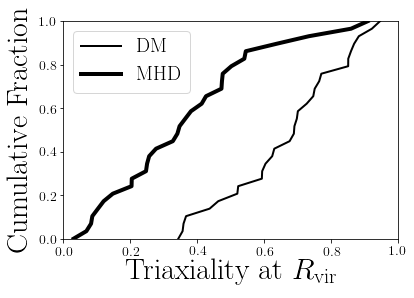

In [70]:
plt.plot(np.sort(T_DM[:,i_radius_vir]), np.linspace(0,1,30), label='DM', linewidth=2, color='black')
plt.plot(np.sort(T_MHD[:,i_radius_vir]), np.linspace(0,1,30), label='MHD', linewidth=4, color='black')
plt.xlabel(r"Triaxiality at $R_{\rm vir}$")
plt.ylabel("Cumulative Fraction")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(fontsize=20)

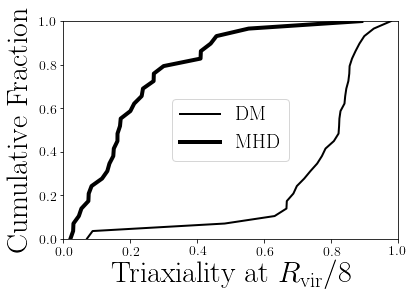

In [71]:
plt.plot(np.sort(T_DM[:,i_radius_vir_8]), np.linspace(0,1,30), label='DM', linewidth=2, color='black')
plt.plot(np.sort(T_MHD[:,i_radius_vir_8]), np.linspace(0,1,30), label='MHD', linewidth=4, color='black')
plt.xlabel(r"Triaxiality at $R_{\rm vir}/8$")
plt.ylabel("Cumulative Fraction")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(fontsize=20)

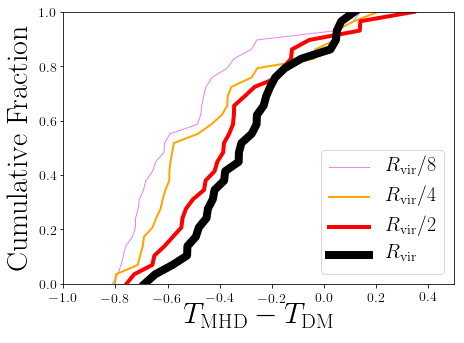

In [112]:
plt.figure(figsize=(7,5))

plt.plot(np.sort(delta_T[:,0]), np.linspace(0,1,30), label=r'$R_{\rm vir}/8$', linewidth=1, color='violet')
plt.plot(np.sort(delta_T[:,1]), np.linspace(0,1,30), label=r'$R_{\rm vir}/4$', linewidth=2, color='orange')
plt.plot(np.sort(delta_T[:,2]), np.linspace(0,1,30), label=r'$R_{\rm vir}/2$', linewidth=4, color='red')
plt.plot(np.sort(delta_T[:,3]), np.linspace(0,1,30), label=r'$R_{\rm vir}$', linewidth=8, color='black')

plt.xlabel(r"$T_{\rm MHD} - T_{\rm DM}$")
plt.ylabel("Cumulative Fraction")
plt.xlim([-1,0.5])
plt.ylim([0,1])
plt.legend(fontsize=20)
plt.savefig("../Document/delta_triaxialiy_distro.pdf", bbox_inches='tight')

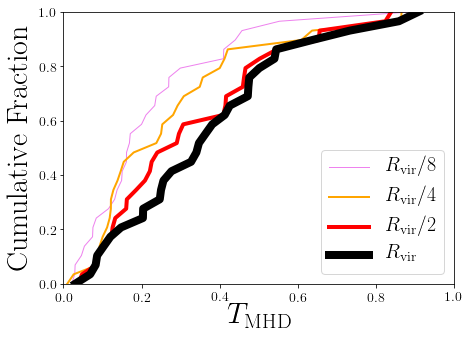

In [113]:
plt.figure(figsize=(7,5))

plt.plot(np.sort(T_MHD[:,0]), np.linspace(0,1,30), label=r'$R_{\rm vir}/8$', linewidth=1, color='violet')
plt.plot(np.sort(T_MHD[:,1]), np.linspace(0,1,30), label=r'$R_{\rm vir}/4$', linewidth=2, color='orange')
plt.plot(np.sort(T_MHD[:,2]), np.linspace(0,1,30), label=r'$R_{\rm vir}/2$', linewidth=4, color='red')
plt.plot(np.sort(T_MHD[:,3]), np.linspace(0,1,30), label=r'$R_{\rm vir}$', linewidth=8, color='black')

plt.xlabel(r"$T_{\rm MHD}$")
plt.ylabel("Cumulative Fraction")
plt.xlim([0,1.0])
plt.ylim([0,1])
plt.legend(fontsize=20)
plt.savefig("../Document/triaxialiy_distro_MHD.pdf", bbox_inches='tight')

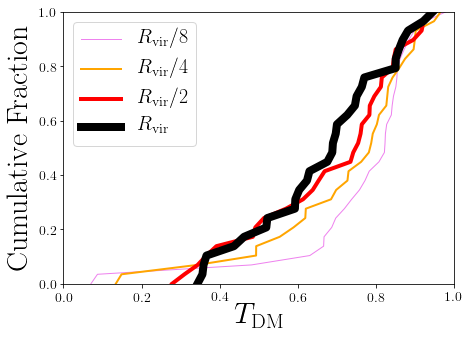

In [114]:
plt.figure(figsize=(7,5))
plt.plot(np.sort(T_DM[:,0]), np.linspace(0,1,30), label=r'$R_{\rm vir}/8$', linewidth=1, color='violet')
plt.plot(np.sort(T_DM[:,1]), np.linspace(0,1,30), label=r'$R_{\rm vir}/4$', linewidth=2, color='orange')
plt.plot(np.sort(T_DM[:,2]), np.linspace(0,1,30), label=r'$R_{\rm vir}/2$', linewidth=4, color='red')
plt.plot(np.sort(T_DM[:,3]), np.linspace(0,1,30), label=r'$R_{\rm vir}$', linewidth=8, color='black')

plt.xlabel(r"$T_{\rm DM}$")
plt.ylabel("Cumulative Fraction")
plt.xlim([0,1.0])
plt.ylim([0,1])
plt.legend(fontsize=20)
plt.savefig("../Document/triaxialiy_distro_DM.pdf", bbox_inches='tight')

In [115]:
properties = np.loadtxt("../Data/Halo_General/Level 4/level4_properties.txt")

In [117]:
np.shape(properties)

(30, 13)

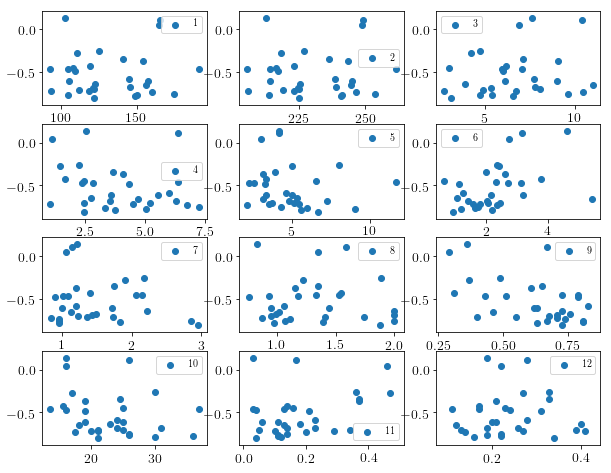

In [142]:
plt.figure(figsize=(10,8))
for i_plot in range(1,13):
    plt.subplot(4,3,i_plot)
    plt.scatter( properties[:,i_plot], delta_T[:,0],label='{}'.format(i_plot))
    plt.legend()

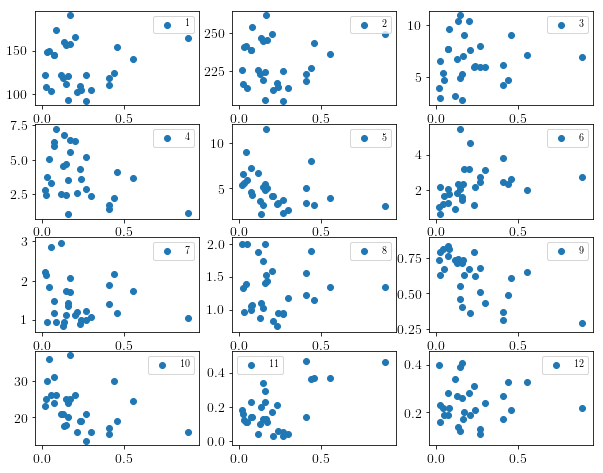

In [141]:
plt.figure(figsize=(10,8))
for i_plot in range(1,13):
    plt.subplot(4,3,i_plot)
    plt.scatter(T_MHD[:,0], properties[:,i_plot], label='{}'.format(i_plot))
    plt.legend()